## imports

In [ ]:
from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from pathlib import Path
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image, resize, to_tensor
from torchvision.transforms.functional import normalize
# from tqdm.notebook import tqdm
import os
import random

In [ ]:
SEEDS = [0,1,2,3,4]
EPOCHS = 100

## Data 

### functions

In [ ]:
# data import and management

def load_mnist(img_size=32):
    ''' return data and labels for train and test mnist dataset '''
    #---------------- train data -------------------
    mnist_train = datasets.MNIST('data', train=True, download=True)
    data_train = mnist_train.data
    labels_train = [mnist_train[i][1] for i in range(len(data_train))]

    pics = []
    for pic in data_train:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)     # Resize image if needed
        pic = to_tensor(pic)                # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_train = torch.stack(pics)

    #------------------  test data -----------------------
    mnist_test = datasets.MNIST('data', train=False, download=True)
    data_test = mnist_test.data
    labels_test = [mnist_test[i][1] for i in range(len(data_test))]

    pics = []
    for pic in data_test:
        pic = to_pil_image(pic)
        if img_size != 28:
            pic = resize(pic, img_size)     # Resize image if needed
        pic = to_tensor(pic)                # Tensor conversion normalizes in [0,1]
        pics.append(pic)
    data_test = torch.stack(pics)

    return (data_train,labels_train), (data_test,labels_test)

def query(datafull, nb, bias=0, fav=0):
    ''' return -nb random samples of -datafull '''
    data, labels = datafull
    idxs = list(range(len(data)))
    l = []
    h, w = data[0][0].shape
    d = torch.empty(nb, 1, h, w)
    if bias == 0:
        indexes = random.sample(idxs, nb) # drawing nb random indexes
    else :
        indexes = []
        for i in range(nb):
            idx = one_query(labels, idxs, bias, fav)
            indexes.append(idx)
            idxs.remove(idx) # to draw only once each index max
    for k, i in enumerate(indexes): # filling our query
        d[k] = data[i]
        l.append(labels[i])
    return d, l

def one_query(labels, idxs, redraws, fav):
    ''' labels : list of labels
        idxs : list of available indexes
        draws an index with a favorite label choice 
        fav : favorite label
        redraws : max nb of random redraws while fav not found
    '''
    lab = -1 
    while lab != fav and redraws >= 0:
        idx = idxs[random.randint(0, len(idxs)-1)]
        lab = labels[idx]
        redraws -= 1
    return idx

def list_to_longtens(l):
    ''' change a list into torch.long tensor '''
    tens = torch.empty(len(l), dtype=torch.long)  
    for i, lab in enumerate(l):                       
        tens[i] = lab
    return tens

def swap(l, n, m):
    ''' swap n and m values in l list '''
    return [m if (v==n) else n if (v==m) else v for v in l]


def distribute_data_rd(datafull, distrib, fav_lab=(0,0), dish=False, dish_lab=0, gpu=True): 
    '''draw random data on N nodes following distrib
        data, labels : raw data and labels
        distrib : int list, list of nb of data points for each node
        pref_lab : (prefered label, strength of preference (int))
        dish : boolean, if nodes are dishonest 
        dish_lab : 0 to 4, labelisation method

        returns : (list of batches of images, list of batches of labels)
    '''
    global FORCING1
    global FORCING2
    data, labels = datafull
    N = len(distrib)
    data_dist = []      # list of len N
    labels_dist = []    # list of len N
    fav, strength = fav_lab

    for n, number in enumerate(distrib): #for each node
        # if strength == 0:  # if no preference
        d, l = query(datafull, number, strength, fav)
        # else:
        #     d, l = query(datafull, number, strength, fav)
        if gpu:
            data_dist.append(torch.FloatTensor(d).cuda())
        else:
            data_dist.append(torch.FloatTensor(d))
        if dish:                # if dishonest node

            # labels modification
            if dish_lab == 0: # random
                tens = torch.randint(10, (number,), dtype=torch.long)
            elif dish_lab == 1: # zeros
                tens = torch.zeros(number, dtype=torch.long)
            elif dish_lab == 2: # swap 1-7
                l = swap(l, 1, 7)
                tens = list_to_longtens(l)
            elif dish_lab == 3: # swap 2 random (maybe same)
                n, m = random.randint(0,9), random.randint(0,9)
                l = swap(l, n, m)
                tens = list_to_longtens(l)
                # if FORCING1 == -1:
                #     FORCING1, FORCING2 = random.randint(0,9), random.randint(0,9)
                # l = swap(l, FORCING1, FORCING2)
                # tens = list_to_longtens(l)               
            elif dish_lab == 4: # label +1
                tens = (list_to_longtens(l) + 1) % 10

        else:           # if honest node 
            tens = list_to_longtens(l) # needed for CrossEntropy later
        if gpu:
            tens = tens.cuda()
        labels_dist.append(tens)

    return data_dist, labels_dist 

### get data

In [ ]:
# downloading data
if 'train' not in globals(): # to avoid loading data every time
    train, test = load_mnist()
    test_gpu = torch.tensor(test[0]).cuda(), torch.tensor(test[1]).cuda()

## Model

In [ ]:
#model structure

def get_classifier():
    ''' returns linear baseline classifier '''
    model = nn.Sequential( 
        nn.Flatten(),
        nn.Linear(1024, 10),
        # nn.Sigmoid()
        )
    return model


# def get_classifier():
#     ''' returns classifier '''
#     chan = 16
#     model = nn.Sequential( 
#         nn.Conv2d(1, chan, kernel_size=3, padding=0),
#         nn.Flatten(),
#         nn.Linear(900 * chan, 10),
#         nn.Sigmoid()
#         )
#     return model

# class classifier(nn.Module):
#     '''CNN Model'''
#     def __init__(self):
#         super(classifier, self).__init__()
        
#         # Convolution 1
#         self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16,
#                               kernel_size=3, stride=1, padding=0)
#         self.relu1 = nn.ReLU()
#         # Max pool 1
#         self.maxpool1 = nn.MaxPool2d(kernel_size=2)
#         # Convolution 2
#         self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, 
#                               kernel_size=3, stride=1, padding=0)
#         self.relu2 = nn.ReLU()      
#         # Max pool 2
#         self.maxpool2 = nn.MaxPool2d(kernel_size=2)
#         # Fully connected 1
#         self.fc1 = nn.Linear(32 * 6 * 6, 10) 
    
#     def forward(self, x):
#         # Set 1
#         out = self.cnn1(x)
#         out = self.relu1(out)
#         out = self.maxpool1(out)  
#         # Set 2
#         out = self.cnn2(out)
#         out = self.relu2(out)
#         out = self.maxpool2(out)
#         #Flatten
#         out = out.view(out.size(0), -1)
#         #Dense
#         out = self.fc1(out)
#         return out
# def get_classifier():
#     return classifier()

## Training

### losses

In [ ]:
#loss and scoring functions 

def local_loss(model_loc, x, y):  
    ''' classification loss '''
    loss = nn.CrossEntropyLoss()
    predicted = model_loc(x)
    local = loss(predicted,y)
    return local

def generalisation_loss(model_loc, model_glob, pow):  
    ''' l1 distance between global and local parameter
        will be mutliplied by w_n 
    '''
    q, p = pow
    l1_norm = sum(((theta-rho)**q).abs().sum() for theta, rho in 
                  zip(model_loc.parameters(), model_glob.parameters()))**p
    return l1_norm

def regularisation_loss(model_glob, pow): 
    ''' l2 squared regularisation of global parameter
     will be multiplied by w_0 
     '''
    q, p = pow
    l2_sqr = sum((param**q).abs().sum() for param in model_glob.parameters())**p
    return l2_sqr

def round_loss(tens): 
    '''from an input scalar tensor returns rounded integer'''
    if type(tens)==int or type(tens)==float:
        return int(tens)
    else:
        return int(tens.item())

def tens_count(tens, val):
    ''' counts nb of -val in tensor -tens '''
    return len(tens) - round_loss(torch.count_nonzero(tens-val))

def score(model, datafull):
    ''' returns accuracy provided models, images and GTs '''
    out = model(datafull[0])
    predictions = torch.max(out, 1)[1]
    c=0
    for a, b in zip(predictions, datafull[1]):
        c += int(a==b)
    return c/len(datafull[0])

### Flower

In [ ]:
# nodes repartition

class Flower():
    ''' Training structure including local models and general one 
        Allowing to add and remove nodes at will
        .pop
        .add_nodes
        .rem_nodes
        .train
        .display
        .check
    '''

    def __init__(self, test, w0, opt=optim.Adam, gpu=True):
        ''' opt : optimizer
            test : test data couple (imgs,labels)
            w0 : regularisation strength
        '''
        self.d_test = test
        self.w = w0
        self.gpu = gpu

        self.opt = opt
        self.lr_node = 0.001
        self.lr_gen = 0.001
        self.gen_freq = 1  # generalisation frequency (>0) 
        if self.gpu:
            self.general_model = get_classifier().cuda() 
        else:
            self.general_model = get_classifier() 
        self.opt_gen = self.opt(self.general_model.parameters(), lr=self.lr_gen)
        self.pow_gen = (1,1)  # choice of norms for Licchavi loss 
        self.pow_reg = (2,1)  # (internal power, external power)
        self.data = []
        self.labels = [] 
        self.typ = []
        self.models = []
        self.W = []
        self.age = []
        self.opt_nodes = []
        self.nb_nodes = 0
        self.dic = {"honest" : -1, "trolls" : 0, "zeros" : 1, 
                    "one_evil" : 2, "strats" : 3, "jokers" : 4, "byzantine" : -1}
        self.history = ([], [], [], []) # fit, gen, reg, acc
        self.localtest = ([], []) # (which to pick for each node, list of (data,labels) pairs)

    # ------------ population methods --------------------
    def set_localtest(self, datafull, size, nodes, fav_lab=(0,0), typ="honest"):
        ''' create a local data for some nodes
            datafull : source data
            size : size of test sample
            fav_labs : (label, strength)
            nodes : list of nodes which use this data           
        '''
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size], fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        dtloc = (dt[0], lb[0])
        self.localtest[1].append(dtloc)
        id = len(self.localtest[1]) - 1
        for n in nodes:
            self.localtest[0][n] = id

    def add_nodes(self, datafull, pop, typ, fav_lab=(0,0), w=0.01):
        ''' add nodes to the Flower 
            datafull : data to put on node (sampled from it)
            pop : (nb of nodes, size of nodes)
            typ : type of nodes (str keywords)
            fav_lab : (favorite label, strength)
            w : int, weight of new nodes
        '''
        nb, size = pop
        id = self.dic[typ]
        dish = (id != -1) # boolean for dishonesty
        dt, lb = distribute_data_rd(datafull, [size] * nb, fav_lab,
                                    dish, dish_lab=id, gpu=self.gpu)
        self.data += dt
        self.labels += lb
        self.typ += [typ] * nb
        if self.gpu:
            self.models += [get_classifier().cuda() for i in range(nb)]
        else:
            self.models += [get_classifier() for i in range(nb)]
        self.W += [w] * nb
        self.age += [0] * nb
        for i in range(nb):
            self.localtest[0].append(-1)
        self.nb_nodes += nb
        self.opt_nodes += [self.opt(self.models[n].parameters(), lr=self.lr_node) 
            for n in range(self.nb_nodes - nb, self.nb_nodes) 
            ]
        print("Added {} {} nodes of {} data points".format(nb, typ, size))
        print("Total number of nodes : {}".format(self.nb_nodes))

    def rem_nodes(self, first, last):
        ''' remove nodes of indexes -first (included) to -last (excluded) '''
        nb = last - first
        if last > self.nb_nodes:
            print("-last is out of range, remove canceled")
        else:
            del self.data[first : last]
            del self.labels[first : last] 
            del self.typ[first : last]
            del self.models[first : last]
            del self.W[first : last]
            del self.age[first : last]
            del self.opt_nodes[first : last]
            del self.localtest[0][first : last]
            self.nb_nodes -= nb
            print("Removed {} nodes".format(nb))

    def old(self, years):
        ''' increment age (after training) '''
        for i in range(self.nb_nodes):
            self.age[i] += years
        
    def hm(self, ty):
        ''' count nb of nodes of this type '''
        return self.typ.count(ty)
    
    def pop(self):
        ''' return dictionnary of population '''
        c = {}
        for ty in self.dic.keys():
            c[ty] = self.hm(ty)
        return c

    # ------------- scoring methods -----------
    def score_glob(self, datafull): 
        ''' return accuracy provided images and GTs '''
        return score(self.general_model, datafull)
    
    def test_loc(self, node):
        ''' score of node on local test data '''
        id_data = self.localtest[0][node]
        if id_data == -1:
            # print("No local test data")
            return None
        else:
            nodetest = score(self.models[node], self.localtest[1][id_data])
            return nodetest

    def test_full(self, node):
        ''' score of node on global test data '''
        return score(self.models[node], self.d_test)

    def test_train(self, node):
        ''' score of node on its train data '''
        return score(self.models[node], (self.data[node], self.labels[node]))

    def display(self, node):
        ''' display accuracy for selected node
            node = -1 for global model
        '''
        if node == -1: # global model
            print("global model")
            print("accuracy on test data :", 
                  self.score_glob(self.d_test))
        else: # we asked for a node
            loc_train = self.test_train(node)
            loc_test = self.test_loc(node)
            full_test = self.test_full(node)
            print("node number :", node, ", dataset size :",
                len(self.labels[node]), ", type :", self.typ[node], 
                ", age :", self.age[node])
            print("accuracy on local train data :", loc_train)
            print("accuracy on local test data :", loc_test)
            print("accuracy on global test data :", full_test)
            repart = {str(k) : tens_count(self.labels[node], k) 
                for k in range(10)}
            print("labels repartition :", repart)

    # --------------------   TRAINING -------------------      
    def train(self, nb_epochs=10, test_freq=1, verbose=2):   
        '''training loop'''
        time_train = time()

        for n in range(self.nb_nodes):  # updating lr in optimizers
            self.opt_nodes[n].param_groups[0]['lr'] = self.lr_node
        self.opt_gen.param_groups[0]['lr'] = self.lr_gen

        # initialisation to avoid undefined variables
        loss = 0
        fitting_loss = 0
        harmonisation_loss = 0 
        regul_loss = 0
        count_fit, count_gen = 0, 0
        # initialising regulation term for a correct history
        r = regularisation_loss(self.general_model, self.pow_reg) 
        regul_loss = self.w * r  

        epoch = 1
        nb_steps = self.gen_freq + 1
        print("\n")
        while epoch <= nb_epochs:
            if verbose: print("epoch {}/{}".format(epoch, nb_epochs))
            time_ep1 = time()
            for step in range(1, nb_steps + 1):

                # fitting or general step?
                fit_step = (count_fit >= count_gen) 
                if fit_step:
                    count_gen += self.gen_freq
                else:
                    count_fit += 1              
                if verbose >= 2: print("step :",step,'/',nb_steps, 
                                        "(fit)" if fit_step else "(gen)")
                # resetting optimizers
                for n in range(self.nb_nodes):
                    self.opt_nodes[n].zero_grad()      
                self.opt_gen.zero_grad()

                #----------------    Licchavi loss  -------------------------
                if fit_step: # only first 2 terms of loss updated
                    fitting_loss = 0
                    harmonisation_loss = 0 
                    diff = 0  # used to print correct loss
                    for n in range(self.nb_nodes):   # for each node
                        if self.typ[n] == "byzantine":
                            fit = local_loss(self.models[n], 
                                                self.data[n], self.labels[n])
                            fitting_loss -= fit
                            diff += 2 * fit
                        else:
                            fitting_loss += local_loss(self.models[n], 
                                                self.data[n], self.labels[n])
                        g = generalisation_loss(self.models[n], 
                                                self.general_model, self.pow_gen)
                        harmonisation_loss +=  self.W[n] * g  # generalisation term   
                    loss = fitting_loss + harmonisation_loss 
                    epoch += 1 # only for fitting steps       

                else: # only last 2 terms of loss updated        
                    harmonisation_loss = 0 
                    regul_loss = 0
                    for n in range(self.nb_nodes):   # for each node
                        g = generalisation_loss(self.models[n], 
                                                self.general_model, self.pow_gen)
                        harmonisation_loss += self.W[n] * g  #generalisation term    
                    r = regularisation_loss(self.general_model, self.pow_reg) 
                    regul_loss = self.w * r   # regul term  
                    loss = harmonisation_loss + regul_loss

                total_out = round_loss(fitting_loss + diff
                    + harmonisation_loss + regul_loss)
                if verbose >= 2:
                    print("total loss : ", total_out)  # printing losses
                    print("fitting : ", round_loss(fitting_loss + diff),
                        ', harmonisation : ', round_loss(harmonisation_loss),
                        ', regularisation : ', round_loss(regul_loss))
                
 

                # ---------------------   Gradient descent ---------------------
                loss.backward()      # backpropagation
                if fit_step:       # updating local or global alternatively
                    for n in range(self.nb_nodes): 
                        self.opt_nodes[n].step()      # updating nodes weights 
                else:
                    self.opt_gen.step()       # updating general weights

                # --------- end of step --------------
            if verbose: 
                print("epoch time :", round(time() - time_ep1, 2))
            if epoch % test_freq == 0:   # printing accuracy on test data
                acc = self.score_glob(self.d_test)
                if verbose: print("TEST ACCURACY : ", acc)
                for i in range(test_freq):
                    self.history[3].append(acc) 
            self.history[0].append(round_loss(fitting_loss))
            self.history[1].append(round_loss(harmonisation_loss))
            self.history[2].append(round_loss(regul_loss))
            self.old(1)  # aging all nodes
            if verbose: print("\n") # end of epoch

            
        # ----------------- end of training -------------------------------  
        
        for i in range(nb_epochs % test_freq): # to maintain same history length
            self.history[3].append(acc)
        print("training time :", round(time() - time_train, 2)) 
        return self.history
    
    def check(self):
        ''' perform some tests on internal parameters adequation '''
        b1 =  (self.nb_nodes == len(self.data) == len(self.labels) 
            == len(self.typ) == len(self.models) == len(self.opt_nodes) 
            == len(self.W) == len(self.age) == len(self.localtest[0]))
        b2 = (len(self.history[0]) == len(self.history[1]) 
            == len(self.history[2]) == len(self.history[3]) >= max(self.age))
        b3 = (max(self.localtest[0]) <= len(self.localtest[1]) - 1)
        if (b1 and b2 and b3):
            print("No Problem")
        else:
            print("OULALA non ça va pas là")

def get_flower(w=0.05, gpu=True):
    ''' get a Flower using the appropriate test data (gpu or not) '''
    if gpu:
        return Flower(test_gpu, w, gpu=gpu)
    else:
        return Flower(test, w, gpu=gpu)

## Getting plots

### plotting utilities

In [ ]:
def get_style():
    '''give different line styles for plots'''
    l = ["-","-.","--",":"]
    for i in range(10000):
        yield l[i % 4]
STYLES = get_style() # generator for looping styles

def title_save(title=None, path=None, suff=".png"):
    ''' add title and save plot '''
    if title is not None:   
        plt.title(title)
    if path is not None:
        plt.savefig(path + suff)

def legendize(x, y):
    ''' label axis of plt plot '''
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()

### plotting from history

In [ ]:
# functions to display training history 

def means_bounds(arr):
    ''' from array return 1 array of means, 
        1 for mean -var, one for mean + var
    '''
    means = np.mean(arr, axis=0)
    var = np.var(arr, axis = 0) *10
    low, up = means - var, means + var
    return means, low, up

def acc_var(l_hist, title=None, path=None):
    ''' plot accuracy with variance from a list of historys '''
    l_acc = [h[3] for h in l_hist]
    arr = np.asarray(l_acc)
    means, low, up = means_bounds(arr)
    epochs = range(1, len(means) + 1)
    plt.plot(epochs, means, label='acc', linestyle=next(STYLES))
    plt.fill_between(epochs, up, low, alpha=0.4)
    plt.ylim([0,1])
    legendize("Epochs", "Test Accuracy")
    if title is not None:
        plt.title(title)
    if path is not None:
        plt.savefig(path + "_acc.png")
    plt.show()

def loss_var(l_hist, title=None, path=None):
    ''' plot losses with variance from a list of historys '''
    intens = 0.4
    arr_hist = np.asarray(l_hist)
    fit = arr_hist[:,0,:]
    gen = arr_hist[:,1,:]
    reg = arr_hist[:,2,:]
    tot = fit + gen + reg

    tot_m, tot_l, tot_u = means_bounds(tot)
    fit_m, fit_l, fit_u = means_bounds(fit)
    gen_m, gen_l, gen_u = means_bounds(gen)
    reg_m, reg_l, reg_u = means_bounds(reg)

    epochs = range(1, len(tot_m) + 1)
    plt.plot(epochs, tot_m, label='tot', linestyle='-', color='red')
    plt.plot(epochs, fit_m, label='fit', linestyle='-.', color='green')
    plt.plot(epochs, gen_m, label='gen', linestyle=':', color='blue')
    plt.plot(epochs, reg_m, label='reg', linestyle='--', color='orange')

    plt.fill_between(epochs, tot_u, tot_l, alpha=intens, color='red')
    plt.fill_between(epochs, fit_u, fit_l, alpha=intens, color='green')
    plt.fill_between(epochs, gen_u, gen_l, alpha=intens, color='blue')
    plt.fill_between(epochs, reg_u, reg_l, alpha=intens, color='orange')

    legendize("Epochs","Training loss")
    title_save(title, path, suff="_loss.png")
    plt.show()

def show_acc(flow, title=None, path=None):
    ''' plot curves of accuracy evolution of a Flower '''
    acc = flow.history[3]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, label='acc')
    plt.ylim([0,1])
    legendize("Epochs", "Test Accuracy")
    title_save(title, path, suff="_acc.png")
    plt.show()

def show_loss(flow, title=None, path=None):
    ''' plot curves of loss evolution of a Flower '''
    fit, gen, reg, _ = flow.history
    tot = [a + b + c for a, b, c in zip(fit, gen, reg)]
    epochs = range(1, len(fit) + 1)
    plt.plot(epochs, tot, label='tot', linestyle='-', color='red')
    plt.plot(epochs, fit, label='fit', linestyle='-.')
    plt.plot(epochs, gen, label='gen', linestyle=':')
    plt.plot(epochs, reg, label='reg', linestyle='--')      #outputs results as a plot
    legendize("Epochs", "Training loss")
    title_save(title, path, suff="_loss.png")
    plt.show()

In [ ]:
seeds=[1,2]

### running and plotting

In [ ]:
# functions to train and display history at the end

def seedall(s):
    '''seed all sources of randomness'''
    reproducible = (s >= 0)
    torch.manual_seed(s)
    random.seed(s)
    np.random.seed(s)
    torch.backends.cudnn.deterministic = reproducible
    torch.backends.cudnn.benchmark     = not reproducible
    print("seeded all to", s)

def add_acc_var(arr, label='acc'):
    ''' from array adds curve of accuracy '''
    acc = arr[:,3,:]
    means, low, up = means_bounds(acc)
    epochs = range(1, len(means) + 1)
    plt.plot(epochs, means, label=label, linestyle=next(STYLES))
    plt.fill_between(epochs, up, low, alpha=0.4)

def plot_runs_acc(l_runs, l_param, path=None):
    ''' plot several acc_var on one graph, -l_param is for legend'''
    arr = np.asarray(l_runs)
    for run, param in zip(arr, l_param): # adding one curve for each parameter (run)
        add_acc_var(run, str(param))
    plt.ylim([0,1])
    legendize("Epochs", "Test Accuracy")
    title_save(title=path, path=path, suff=".png")
    plt.show()

# ---------- number of honest nodes -------------------------

def get_fower_disp(nbn, gpu=True):
    '''initialize a flower and add -nbn honest nodes'''
    w0 = 0.05 * nbn
    ppn = 60_000 // nbn # points per node
    flow = get_flower(w0, gpu)
    flow.add_nodes(train, (nbn, ppn), "honest", w=0.005)
    return flow

def run_disp(nbn, verbose=0, gpu=True):
    ''' create a flower of honest nodes and trains it for 200 eps
        display graphs of loss and accuracy 
        nbn : number of nodes
    '''
    l_hist = []
    for s in SEEDS: # different seeds (global variable)
        seedall(s)
        flow = get_fower_disp(nbn, gpu=True)   
        epochs = EPOCHS
        flow.lr_node = 0.001
        flow.lr_gen = 0.01
        flow.gen_freq = 1
        h = flow.train(epochs, verbose=verbose)
        flow.check()
        l_hist.append(h)
        print("\n")
    text = "nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}"
    title = text.format(nbn, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs)
    path = "disp/disp_{}".format(nbn)
    acc_var(l_hist, title, path)
    loss_var(l_hist, title, path)    
    return l_hist # all historys

def run_disp_mult(l_nbn, verbose=0, gpu=True):
    ''' iterate run_disp with a list of different parameters '''
    l_runs = [] # list of historys for each parameter
    os.makedirs("disp", exist_ok=True)
    for nbn in l_nbn:
        l_hist = run_disp(nbn, verbose, gpu)
        l_runs.append(l_hist)
    plot_runs_acc(l_runs, l_nbn, "disp/disp_mult")


# ----------- proportion of dishonest nodes  ------------

def get_flower_fracbyz(frac, typ, gpu=True):
    ''' initialize and add nodes according to parameters '''
    nbn = 1000
    w0 = 0.05 * nbn
    flow = get_flower(w0, gpu)
    ppn = 60_000 // nbn # points per node
    nbbyz = int(frac * nbn)
    nbh = nbn - nbbyz
    flow.add_nodes(train, (nbh, ppn), "honest", w=0.005)
    flow.add_nodes(train, (nbbyz, ppn), typ, w=0.005)
    return flow

def run_fracbyz(frac, typ, verbose=0, gpu=True):
    ''' create a flower of honest nodes and trains it for 200 eps
        display graphs of loss and accuracy 
        frac : fraction of dishonest nodes
    '''
    l_hist = []
    for s in SEEDS:
        seedall(s)
        flow = get_flower_fracbyz(frac, typ, gpu)
        epochs = EPOCHS
        flow.lr_node = 0.001
        flow.lr_gen = 0.01
        flow.gen_freq = 1
        h = flow.train(epochs, verbose=verbose)
        flow.check()
        l_hist.append(h)
    text = "frac : {}, nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}"
    title = text.format(frac, flow.nb_nodes, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs)
    path = "fracbyz/fracdish_{}".format(int(100*frac)) # percentage
    acc_var(l_hist, title, path)
    loss_var(l_hist, title, path)    
    return l_hist

def run_fracbyz_mult(l_frac, typ="zeros", verbose=0, gpu=True):
    '''iterate run_fracbyz with a list of fracs'''
    l_runs = [] # list of historys for each parameter
    os.makedirs("fracbyz", exist_ok=True)
    for frac in l_frac:
        l_hist = run_fracbyz(frac, typ, verbose, gpu)
        l_runs.append(l_hist)
    plot_runs_acc(l_runs, l_frac, "fracbyz/fracbyz_mult")

# ------------- heterogeneity of data --------------------

def get_flower_heter(heter, frac=0, typ="zeros", gpu=True):
    ''' initialize and add nodes according to parameters ''' 
    nbn = 1000
    w0 = 0.05 * nbn
    flow = get_flower(w0, gpu)
    ppn = 60_000 // nbn # points per node
    nbbyz = int(frac * nbn)
    nbh = nbn - nbbyz
    nbh_lab = nbh // 10 # for each label
    nbbyz_lab = nbbyz // 10
    nb_lab = nbh_lab + nbbyz_lab
    for lab in range(10): # for each label
        flow.add_nodes(train, (nbh_lab, ppn), "honest", (lab, heter), w=0.005)
        flow.add_nodes(train, (nbbyz_lab, ppn), typ, (lab, heter), w=0.005)
        if gpu:
            flow.set_localtest(test_gpu, 100, range(lab * nb_lab, (lab + 1) * nb_lab), (lab, heter))
        else:
            flow.set_localtest(test, 100, range(lab * nb_lab, (lab + 1) * nb_lab), (lab, heter))
    return flow

def run_heter(heter, frac=0, typ="zeros", verbose=0, gpu=True):
    ''' create a flower of honest nodes and trains it for 200 eps
        display graphs of loss and accuracy 
        frac : fraction of dishonest nodes
        heter : heterogeneity of data
    '''
    l_hist = []
    for s in SEEDS:
        seedall(s)
        flow = get_flower_heter(heter, frac, typ, gpu)
        epochs = EPOCHS
        flow.lr_node = 0.001
        flow.lr_gen = 0.01
        flow.gen_freq = 1
        h = flow.train(epochs, verbose=verbose)
        flow.check()
        l_hist.append(h)
    t1 = "heter : {}, nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}" 
    t2 = "\nfrac : {}, type : " + typ 
    text = t1 + t2
    title = text.format(heter, flow.nb_nodes, flow.lr_node, 
                        flow.lr_gen, flow.gen_freq, epochs, frac)
    path = "heter/heter_{}".format(heter)
    acc_var(l_hist, title, path)
    loss_var(l_hist, title, path)      
    return l_hist

def run_heter_mult(l_heter, frac=0, typ="zeros", verbose=0, gpu=True):
    '''iterate run_heter with a list of fracs'''
    l_runs = [] # list of historys for each parameter
    os.makedirs("heter", exist_ok=True)
    for heter in l_heter:
        l_hist = run_heter(heter, frac, typ, verbose, gpu)
        l_runs.append(l_hist)
    plot_runs_acc(l_runs, l_heter, "heter/heter_mult")

In [ ]:
# def run_heter_strats(heter, gpu=True):
#     ''' create a flower of honest nodes and trains it for 200 eps
#         display graphs of loss and accuracy 
#         frac : fraction of dishonest nodes
#         heter : heterogeneity of data
#     '''
#     global FORCING1
#     global FORCING2
#     nbn = 1000
#     w0 = 0.05 * nbn
#     flow = get_flower(w0, gpu)
    
#     ppn = 60_000 // nbn # points per node
#     nb_lab = nbn // 10
#     for lab in range(10):
#         for n in range(nb_lab):
#             FORCING1, FORCING2 = -1, -1
#             flow.add_nodes(train, (1, ppn), "strats", (lab, heter), w=0.005)
#             flow.set_localtest(test_gpu, 100, [lab * nb_lab + n], (lab, heter), typ="strats")

#     epochs = 200
#     flow.lr_node = 0.001
#     flow.lr_gen = 0.01
#     flow.gen_freq = 1
#     flow.train(epochs, test_freq=2)
#     flow.check()
#     t1 = "heter : {}, nbn : {}, lrnode : {}, lrgen : {}, genfrq : {}, eps :{}" 
#     t2 = "\ntype : only strats" 
#     text = t1 + t2
#     title = text.format(heter, nbn, flow.lr_node, 
#                         flow.lr_gen, flow.gen_freq, epochs)
#     show_acc(flow, title)
#     show_loss(flow, title)    
#     return flow

seeded all to 1
Added 1 honest nodes of 60000 data points
Total number of nodes : 1


epoch 1/2
step : 1 / 2 (fit)
total loss :  3
fitting :  2 , harmonisation :  1 , regularisation :  0
step : 2 / 2 (gen)
total loss :  3
fitting :  2 , harmonisation :  1 , regularisation :  0
epoch time : 0.01
TEST ACCURACY :  0.0873


epoch 2/2
step : 1 / 2 (fit)
total loss :  3
fitting :  2 , harmonisation :  0 , regularisation :  0
step : 2 / 2 (gen)
total loss :  3
fitting :  2 , harmonisation :  0 , regularisation :  0
epoch time : 0.01
TEST ACCURACY :  0.193


training time : 0.47
No Problem




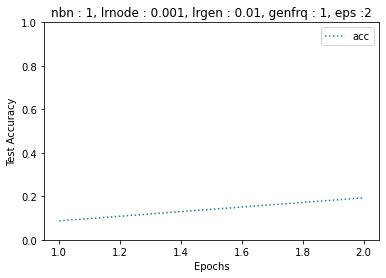

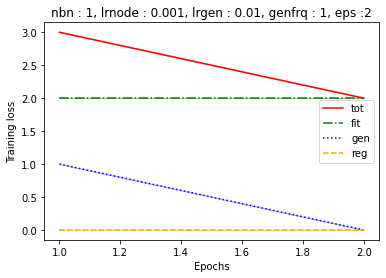

seeded all to 1
Added 100 honest nodes of 600 data points
Total number of nodes : 100


epoch 1/2
step : 1 / 2 (fit)
total loss :  355
fitting :  231 , harmonisation :  106 , regularisation :  16
step : 2 / 2 (gen)
total loss :  351
fitting :  231 , harmonisation :  103 , regularisation :  16
epoch time : 0.14
TEST ACCURACY :  0.0379


epoch 2/2
step : 1 / 2 (fit)
total loss :  328
fitting :  225 , harmonisation :  86 , regularisation :  16
step : 2 / 2 (gen)
total loss :  315
fitting :  225 , harmonisation :  84 , regularisation :  5
epoch time : 0.15
TEST ACCURACY :  0.2524


training time : 0.8
No Problem




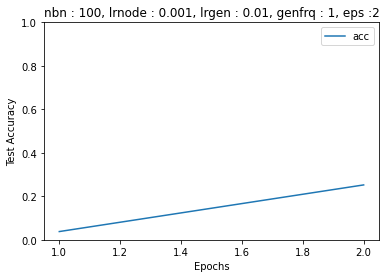

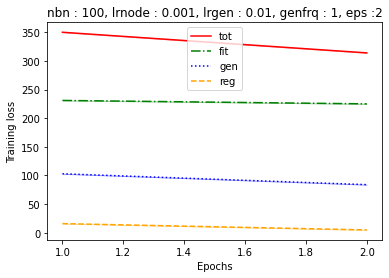

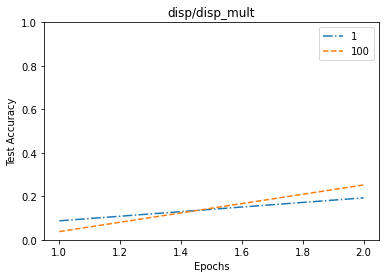

In [ ]:
EPOCHS = 100
SEEDS = [1,2,3]
l_disp = [1,100]
l_hist = run_disp_mult(l_disp, verbose=2, gpu=True)

### comparison

In [ ]:
 def compare(flow_centr, flow_distr):
    ''' return average accuracy on local test sets 
        for both centralized and distributed models
    '''
    central, gen, distr = 0, 0, 0
    N = flow_distr.nb_nodes
    for lab in range(10):
        sc = score(flow_centr.models[0], flow_distr.localtest[1][lab])
        central += sc
    for lab in range(10):
        sc = score(flow_distr.general_model, flow_distr.localtest[1][lab])
        gen += sc
    for n in range(N):
        sc = flow_distr.test_loc(n)
        distr += sc
    distr = distr / N
    central = central / 10
    gen = gen / 10
    return central, gen, distr

 def compare2(flow_centr, flow_distr): # for testing with one data test 
    ''' return average accuracy on local test sets 
        for both centralized and distributed models
    '''
    central, gen, distr = 0, 0, 0
    N = flow_distr.nb_nodes
    for n in range(N):
        sc = score(flow_centr.models[0], flow_distr.localtest[1][n])
        central += sc
    for n in range(N):
        sc = score(flow_distr.general_model, flow_distr.localtest[1][n])
        gen += sc
    for n in range(N):
        sc = flow_distr.test_loc(n)
        distr += sc
    distr = distr / N
    central = central / N
    gen = gen / N
    return central, gen, distr 

#Manual

In [ ]:
seedall(0)
tulip = get_flower_ep(0.05, gpu=True)
tulip.add_nodes(train, (1, 60000), "honest", w=0.05)
tulip.check()
tulip.w = 0.5
tulip.lr_node = 0.1
tulip.lr_gen = 0.01
tulip.gen_freq = 3
h1 = tulip.train(10, test_freq=2, verbose=2)
tulip.check()